# Island 와 stepping-stone models
<예시>
![exp](http://bio.research.ucsc.edu/~barrylab/classes/evolution/Image1.gif)

a) continent-island or source-sink: one-way gene flow from a continent which has a large population to a smaller "island" population;

b) island model 은 islands에 같은 확률로 migration이 일어날수 있다고 가정. in which migration occurs among islands (usually all islands have equal probabilities of receiving dispersing individuals and thus the migration rate or gene flow is considered to be equally distributed among all islands);

c) stepping stone model 은 인접한 islands 에서만 migration이 일어난다고 가정. 

=> 이번에는 **F**st (fixation index) 를  subpopulation level 과 meta-population level 에서 위의 두 모델을 이용하여 simulation 해본다.

## 참고자료

**Fixation index**경

1. variance of allele frequencies between populations
2. probability of Identity by descent.
<계산방법>
![exp](https://upload.wikimedia.org/math/2/c/0/2c03284ed3feabfbf4fdca545e91206c.png)

two individuals sampled from different sub-populations or from the same sub-population
 => 두 집단의 이질성이 높을 수록 bias 가 심화되기 때문에, 실제로는 Weir & Cockerham (1984) 이 만든 수정된 방법을 이용.


In [1]:
from __future__ import division
# Python 3.0 방식으로 계산하도록 변경...: 1 / 2 --> 0.5 or 4 / 2 --> 2.0

from collections import defaultdict, OrderedDict
from copy import deepcopy

import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt

import simuPOP as sp
from simuPOP import demography
%matplotlib inline

simuPOP Version 1.1.6 : Copyright (c) 2004-2011 Bo Peng
Revision 4972 (May  1 2015) for Python 2.7.9 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0xa3736395058720ff.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


/home/seung-hyun/anaconda/envs/bioinformatics/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
num_loci = 10
pop_size = 50
num_gens = 101
num_pops = 10 # simulating 10 islands.
migs = [0, 0.005, 0.01, 0.02, 0.05, 0.1] # migration rate 를 설정.

In [4]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [5]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        if accumulator.endswith('_sp'): # sp option => variables 를 subpopulations 에서 계산을 해준다. 여기서는 10 islands 각각에 해당.
            pop.vars()[accumulator] = defaultdict(list)
        else:
            pop.vars()[accumulator] = []
    return True

def update_accumulator(pop, param):
    accumulator, var = param
    if  var.endswith('_sp'):
        for sp in range(pop.numSubPop()):
            pop.vars()[accumulator][sp].append(deepcopy(pop.vars(sp)[var[:-3]]))
    else:
        pop.vars()[accumulator].append(deepcopy(pop.vars()[var]))
    return True

In [6]:
pops = sp.Population([pop_size] * num_pops, loci=[1] * num_loci, infoFields=['migrate_to']) # migration 을 지정.

In [7]:
# operator 를 설정
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['fst'])
init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5])
for i, mig in enumerate(migs):
    post_ops['mig-%d' % i] = sp.Migrator(demography.migrIslandRates(mig, num_pops), reps=[i]) # island migration 설정.
post_ops['Stat-fst'] = sp.Stat(structure=sp.ALL_AVAIL)
post_ops['fst_accumulation'] = sp.PyOperator(update_accumulator, param=('fst', 'F_st'))

In [8]:
mating_scheme = sp.RandomMating() # random mating

In [9]:
# simulation 시작
sim = sp.Simulator(pops, rep=len(migs)) # replication 할때 migration rate 을 변화시킴.
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

(101L, 101L, 101L, 101L, 101L, 101L)

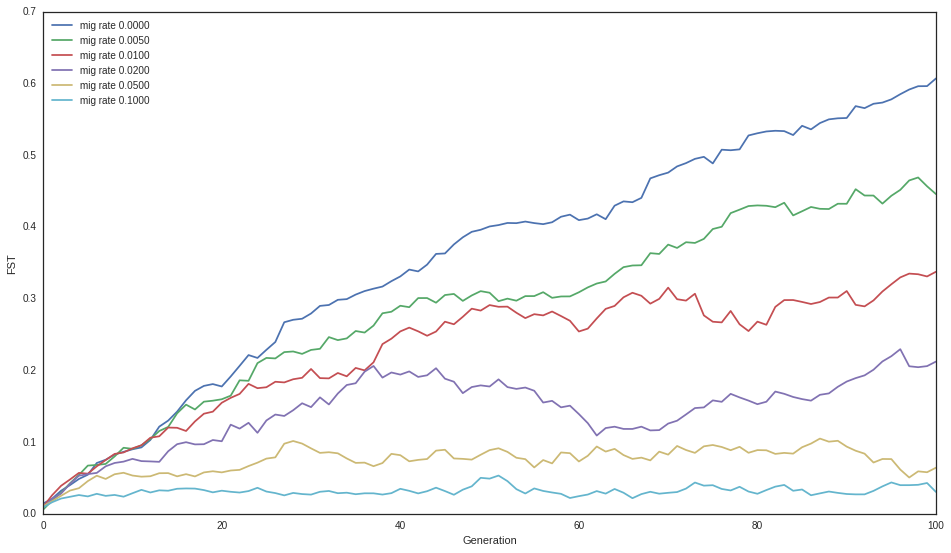

In [10]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
for i, pop in enumerate(sim.populations()):
    ax.plot(pop.dvars().fst, label='mig rate %.4f' % migs[i])
ax.legend(loc=2)
ax.set_ylabel('FST')
ax.set_xlabel('Generation')

In [11]:

# computing and storing allele frequencies per subpopulation (alleleFreq_sp) and at the meta population level (alelleFreq).

num_gens = 400
num_loci = 5
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()
init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL, vars=['alleleFreq', 'alleleFreq_sp'])
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['allele_freq', 'allele_freq_sp'])
post_ops['freq_accumulation'] = sp.PyOperator(update_accumulator, param=('allele_freq', 'alleleFreq'))
post_ops['freq_sp_accumulation'] = sp.PyOperator(update_accumulator,
                                                 param=('allele_freq_sp', 'alleleFreq_sp'))

In [12]:
for i, mig in enumerate(migs):
    post_ops['mig-%d' % i] = sp.Migrator(demography.migrSteppingStoneRates(mig, num_pops), reps=[i]) 

# stepping-stone model instead of the island model.

pops = sp.Population([pop_size] * num_pops, loci=[1] * num_loci, infoFields=['migrate_to'])

In [13]:
sim = sp.Simulator(pops, rep=len(migs))
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

(400L, 400L, 400L, 400L, 400L, 400L)

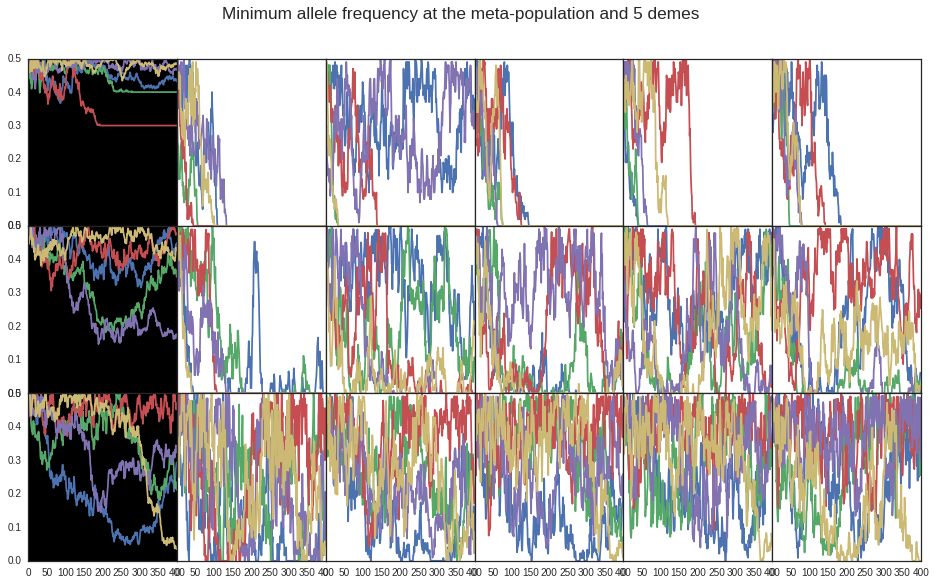

In [14]:
# plot the minimum allele frequency for every locus on the meta population level and on each deme
# black background : evolution at the meta-population level.
# The other 5 charts : evolution in 5 of the 10 demes in the stepping-stone model

# TOP : without migration
# Middle : 0.005 migration
# Bottom : 0.1 migration


def get_maf(var):
    locus_data = [gen[locus] for gen in var]
    maf = [min(freq.values()) for freq in locus_data]
    maf = [v if v != 1 else 0 for v in maf]
    return maf
    
fig, axs = plt.subplots(3, num_pops // 2 + 1, figsize=(16, 9), sharex=True, sharey=True, squeeze=False)
fig.suptitle('Minimum allele frequency at the meta-population and 5 demes', fontsize='xx-large')
for line, pop in enumerate([sim.population(0), sim.population(1), sim.population(len(migs) - 1)]):
    for locus in range(num_loci):
        maf = get_maf(pop.dvars().allele_freq)
        axs[line, 0].plot(maf)
        axs[line, 0].set_axis_bgcolor('black')
    for nsp in range(num_pops // 2):
        for locus in range(num_loci):
            maf = get_maf(pop.dvars().allele_freq_sp[nsp * 2])
            axs[line, nsp + 1].plot(maf)
fig.subplots_adjust(hspace=0, wspace=0)

In [2]:
print 1/2

0.5
